In [1]:
!pip install torch torchvision

    100% |████████████████████████████████| 484.0MB 26kB/s 
tcmalloc: large alloc 1073750016 bytes == 0x5b5ec000 @  0x7ff4d39f51c4 0x46d6a4 0x5fcbcc 0x4c494d 0x54f3c4 0x553aaf 0x54e4c8 0x54f4f6 0x553aaf 0x54efc1 0x54f24d 0x553aaf 0x54efc1 0x54f24d 0x553aaf 0x54efc1 0x54f24d 0x551ee0 0x54e4c8 0x54f4f6 0x553aaf 0x54efc1 0x54f24d 0x551ee0 0x54efc1 0x54f24d 0x551ee0 0x54e4c8 0x54f4f6 0x553aaf 0x54e4c8
    100% |████████████████████████████████| 61kB 14.9MB/s 
    100% |████████████████████████████████| 2.0MB 10.9MB/s 
  Found existing installation: Pillow 4.0.0
    Uninstalling Pillow-4.0.0:
      Successfully uninstalled Pillow-4.0.0


In [2]:
!pip install Pillow==4.1.1

    100% |████████████████████████████████| 5.7MB 6.2MB/s 
  Found existing installation: Pillow 5.1.0
    Uninstalling Pillow-5.1.0:
      Successfully uninstalled Pillow-5.1.0


In [0]:
import os
import numpy as np
import torch
import torchvision
from torch import nn
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import save_image
import pylab
import matplotlib.pyplot as plt

%matplotlib inline

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [0]:
num_epochs = 100
batch_size = 128
learning_rate = 0.001
out_dir = './logs'

if not os.path.exists(out_dir):
    os.mkdir(out_dir)

In [6]:
img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # [0,1] => [-1,1]
])
train_dataset = MNIST('./data', download=True, transform=img_transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

Processing...
Done!


In [7]:
print(len(train_dataset))
print(len(train_loader))

60000
469


In [0]:
class Autoencoder(nn.Module):
    
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 128),
            nn.ReLU(True),
            nn.Linear(128, 64),
            nn.ReLU(True),
            nn.Linear(64, 12),
            nn.ReLU(True),
            nn.Linear(12, 2))
        
        self.decoder = nn.Sequential(
            nn.Linear(2, 12),
            nn.ReLU(True),
            nn.Linear(12, 64),
            nn.ReLU(True),
            nn.Linear(64, 128),
            nn.ReLU(True),
            nn.Linear(128, 28 * 28),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

model = Autoencoder().to(device)

In [9]:
print(model)

Autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU(inplace)
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU(inplace)
    (4): Linear(in_features=64, out_features=12, bias=True)
    (5): ReLU(inplace)
    (6): Linear(in_features=12, out_features=2, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=2, out_features=12, bias=True)
    (1): ReLU(inplace)
    (2): Linear(in_features=12, out_features=64, bias=True)
    (3): ReLU(inplace)
    (4): Linear(in_features=64, out_features=128, bias=True)
    (5): ReLU(inplace)
    (6): Linear(in_features=128, out_features=784, bias=True)
    (7): Tanh()
  )
)


In [0]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),
                             lr=learning_rate,
                             weight_decay=1e-5)

In [0]:
def to_img(x):
    x = 0.5 * (x + 1)  # [-1,1] => [0, 1]
    x = x.clamp(0, 1)
    x = x.view(x.size(0), 1, 28, 28)
    return x

In [12]:
loss_list = []

for epoch in range(num_epochs):
    for data in train_loader:
        img, _ = data
        img = img.to(device)
        x = img.view(img.size(0), -1)
        
        xhat = model(x)
    
        # 出力画像（再構成画像）と入力画像の間でlossを計算
        loss = criterion(xhat, x)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # logging
        loss_list.append(loss.item())

    print('epoch [{}/{}], loss: {:.4f}'.format(
        epoch + 1,
        num_epochs,
        loss.item()))

    # 10エポックごとに再構成された画像（xhat）を描画する
    if epoch % 10 == 0:
        pic = to_img(xhat.to('cpu'))
        save_image(pic, './{}/image_{}.png'.format(out_dir, epoch))

epoch [1/100], loss: 0.2066
epoch [2/100], loss: 0.2014
epoch [3/100], loss: 0.1899
epoch [4/100], loss: 0.1918
epoch [5/100], loss: 0.1708
epoch [6/100], loss: 0.1742
epoch [7/100], loss: 0.1755
epoch [8/100], loss: 0.1554
epoch [9/100], loss: 0.1566
epoch [10/100], loss: 0.1648
epoch [11/100], loss: 0.1498
epoch [12/100], loss: 0.1646
epoch [13/100], loss: 0.1678
epoch [14/100], loss: 0.1485
epoch [15/100], loss: 0.1530
epoch [16/100], loss: 0.1593
epoch [17/100], loss: 0.1437
epoch [18/100], loss: 0.1570
epoch [19/100], loss: 0.1604
epoch [20/100], loss: 0.1560
epoch [21/100], loss: 0.1670
epoch [22/100], loss: 0.1403
epoch [23/100], loss: 0.1519
epoch [24/100], loss: 0.1431
epoch [25/100], loss: 0.1470
epoch [26/100], loss: 0.1483
epoch [27/100], loss: 0.1466
epoch [28/100], loss: 0.1465
epoch [29/100], loss: 0.1349
epoch [30/100], loss: 0.1503
epoch [31/100], loss: 0.1486
epoch [32/100], loss: 0.1391
epoch [33/100], loss: 0.1577
epoch [34/100], loss: 0.1556
epoch [35/100], loss: 0

epoch [83/100], loss: 0.1474
epoch [84/100], loss: 0.1481
epoch [85/100], loss: 0.1501
epoch [86/100], loss: 0.1431
epoch [87/100], loss: 0.1459
epoch [88/100], loss: 0.1399
epoch [89/100], loss: 0.1429
epoch [90/100], loss: 0.1538
epoch [91/100], loss: 0.1444
epoch [92/100], loss: 0.1383
epoch [93/100], loss: 0.1480
epoch [94/100], loss: 0.1474
epoch [95/100], loss: 0.1442
epoch [96/100], loss: 0.1448
epoch [97/100], loss: 0.1378
epoch [98/100], loss: 0.1486
epoch [99/100], loss: 0.1365
epoch [100/100], loss: 0.1377


In [13]:
!ls logs

image_0.png   image_20.png  image_40.png  image_60.png	image_80.png
image_10.png  image_30.png  image_50.png  image_70.png	image_90.png


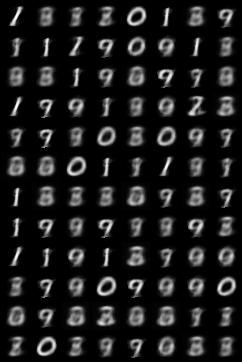

In [14]:
from IPython.display import Image
Image('logs/image_0.png')

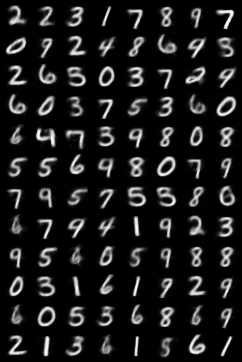

In [15]:
Image('logs/image_90.png')

Text(0,0.5,'loss')

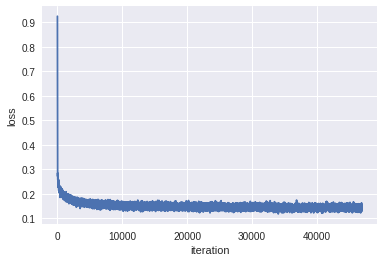

In [16]:
plt.plot(loss_list)
plt.xlabel('iteration')
plt.ylabel('loss')

In [17]:
test_dataset = MNIST('./data', download=True, train=False, transform=img_transform)
test_loader = DataLoader(test_dataset, batch_size=10000, shuffle=False)
print(len(test_dataset))

10000


In [0]:
images, labels = iter(test_loader).next()
images = images.view(10000, -1)

In [19]:
images, labels = iter(test_loader).next()
images = images.view(10000, -1)
print(images.size())
print(labels.size())

torch.Size([10000, 784])
torch.Size([10000])


In [20]:
# 784次元ベクトルを2次元ベクトルにencode
with torch.no_grad():
    z = model.encoder(images.to(device)).to('cpu')
print(z.size())

torch.Size([10000, 2])


In [21]:
z[:10]

tensor([[ -9.9846, -46.5016],
        [ -7.2857,   5.3260],
        [-40.3488,  -6.1231],
        [  3.7391,   1.4791],
        [  0.8074, -10.5423],
        [-27.0218,  -4.4257],
        [ -1.6108,  -6.7165],
        [  3.2521,  -6.5262],
        [ -1.0409,  -1.2222],
        [ -5.6459, -10.6404]])

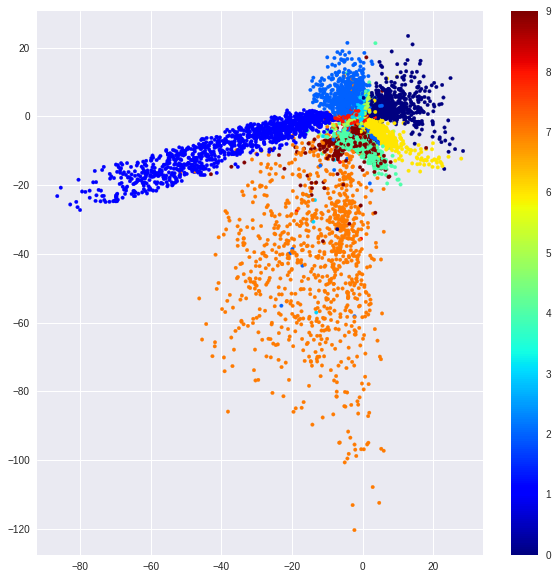

In [22]:
plt.figure(figsize=(10, 10))
plt.scatter(z[:, 0], z[:, 1], marker='.', c=labels.numpy(), cmap=pylab.cm.jet)
plt.colorbar()